In [1]:
from PIL import Image
from os import listdir
from os.path import isdir
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

# Pré-processamento

### Carregar Imagem

In [2]:
desired_size = 160

def select_image(filename):
    # load image from file
    image = Image.open(filename)
    # convert to RGB, if needed
    image = image.convert('RGB')
    
    old_size = image.size
    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    
    image = image.resize(new_size,Image.ANTIALIAS)
    new_im = Image.new("RGB", (desired_size, desired_size))
    new_im.paste(image, ((desired_size-new_size[0])//2,
                    (desired_size-new_size[1])//2))
    
    # convert to array
    return np.asarray(new_im)

### Criar Dataset Personalizado

In [3]:
def load_classes(directory, subdir, imagens, labels):
    

    for filename in listdir(directory):

        path = directory + filename

        try:
            imagens.append(select_image(path))
            labels.append(subdir)
        except:
            print("Erro ao ler imagem {}".format(path))

    return imagens, labels

### Selecionar Dataset

In [4]:
def select_data_set(directory):

    imagens = list()
    labels = list()

    for subdir in listdir(directory):
        # path
        path = directory + subdir + '/'
        
        if not isdir(path):
            continue
        imagens, labels = load_classes(path, subdir, imagens, labels)

    return imagens, labels

In [5]:
dataset = r"/dataset/"
imagens, labels  = select_data_set(dataset)

In [6]:
imagens_array = np.array(imagens) / 255.0  ## convertendo de lista para array

In [7]:
labels_array = np.array(labels)  ## convertendo de lista para array

In [8]:
imagens_array.shape

(6542, 160, 160, 3)

In [9]:
labels_array.shape

(6542,)

## Labels

In [10]:
lb = LabelEncoder()
labels_array = lb.fit_transform(labels_array)
labels_array = to_categorical(labels_array)

In [11]:
labels_array.shape

(6542, 30)

## Hyperparametros

In [12]:
batch_size   = 128
input_shape  = (160, 160, 3)
random_state = 42
alpha        = 1e-5
epoch        = 800

## CALLBACKS

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [14]:
filepath="face.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [15]:
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, min_delta=alpha, patience=100, verbose=1)

In [16]:
callbacks = [checkpoint, lr_reduce]

In [17]:
nsamples, nx, ny, nz = imagens_array.shape
imagens_array = imagens_array.reshape((nsamples,nx*ny*nz))
sm = SMOTE(random_state=random_state)
imagens_array, labels_array = sm.fit_resample(imagens_array, labels_array)

/home/italo/anaconda3/envs/gputest/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [18]:
nsamples, n = imagens_array.shape
imagens_array = imagens_array.reshape(nsamples, nx, ny, nz)

In [19]:
imagens_array.shape

(9240, 160, 160, 3)

In [20]:
(trainX, testX, trainY, testY) = train_test_split(imagens_array, labels_array, test_size=0.20, random_state=random_state)
del imagens_array
del imagens

## DATA AUGMENTATION

In [21]:
train_datagen = ImageDataGenerator(
        horizontal_flip= True,
        rotation_range=20,
        zoom_range=0.2,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        fill_mode='nearest'
        )

train_datagen.fit(trainX)

data_aug = train_datagen.flow(trainX, trainY, batch_size=batch_size)

## TRANSFER LEARNING

In [22]:
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

In [23]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 40, 128)       0     

## Retreinando parte da VGG16

In [24]:
conv_base.trainable = True
set_trainable = False

for layer in conv_base.layers:
  if layer.name == 'block4_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [25]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 40, 128)       0     

## Criando Modelo

In [26]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.BatchNormalization())
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu',input_dim=512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(30, activation='softmax'))

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 5, 5, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              525312    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               5

## Compilar modelo

In [28]:
model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [29]:
history = model.fit(data_aug,
                    epochs=epoch,
                    steps_per_epoch=len(trainX)// batch_size,
                    validation_data=(testX, testY),
                    validation_steps=len(testX) // batch_size,
                    callbacks=callbacks)

Epoch 1/800
57/57 [==============================] - ETA: 0s - loss: 3.4167 - accuracy: 0.0413
Epoch 00001: val_accuracy improved from -inf to 0.03247, saving model to face.h5
57/57 [==============================] - 70s 1s/step - loss: 3.4167 - accuracy: 0.0413 - val_loss: 11.4391 - val_accuracy: 0.0325 - lr: 0.0010
Epoch 2/800
57/57 [==============================] - ETA: 0s - loss: 3.2712 - accuracy: 0.0571
Epoch 00002: val_accuracy improved from 0.03247 to 0.03571, saving model to face.h5
57/57 [==============================] - 60s 1s/step - loss: 3.2712 - accuracy: 0.0571 - val_loss: 6.1460 - val_accuracy: 0.0357 - lr: 0.0010
Epoch 3/800
57/57 [==============================] - ETA: 0s - loss: 3.1008 - accuracy: 0.0611
Epoch 00003: val_accuracy improved from 0.03571 to 0.06439, saving model to face.h5
57/57 [==============================] - 60s 1s/step - loss: 3.1008 - accuracy: 0.0611 - val_loss: 3.1422 - val_accuracy: 0.0644 - lr: 0.0010
Epoch 4/800
57/57 [====================

57/57 [==============================] - 62s 1s/step - loss: 2.1884 - accuracy: 0.2649 - val_loss: 2.1426 - val_accuracy: 0.2798 - lr: 0.0010
Epoch 28/800
57/57 [==============================] - ETA: 0s - loss: 2.1782 - accuracy: 0.2713
Epoch 00028: val_accuracy did not improve from 0.27976
57/57 [==============================] - 60s 1s/step - loss: 2.1782 - accuracy: 0.2713 - val_loss: 2.2888 - val_accuracy: 0.2505 - lr: 0.0010
Epoch 29/800
57/57 [==============================] - ETA: 0s - loss: 2.1586 - accuracy: 0.2778
Epoch 00029: val_accuracy improved from 0.27976 to 0.32900, saving model to face.h5
57/57 [==============================] - 60s 1s/step - loss: 2.1586 - accuracy: 0.2778 - val_loss: 2.0039 - val_accuracy: 0.3290 - lr: 0.0010
Epoch 30/800
57/57 [==============================] - ETA: 0s - loss: 2.1252 - accuracy: 0.2998
Epoch 00030: val_accuracy did not improve from 0.32900
57/57 [==============================] - 60s 1s/step - loss: 2.1252 - accuracy: 0.2998 - val

Epoch 55/800
57/57 [==============================] - ETA: 0s - loss: 1.3805 - accuracy: 0.5486
Epoch 00055: val_accuracy did not improve from 0.53950
57/57 [==============================] - 60s 1s/step - loss: 1.3805 - accuracy: 0.5486 - val_loss: 1.6499 - val_accuracy: 0.5070 - lr: 0.0010
Epoch 56/800
57/57 [==============================] - ETA: 0s - loss: 1.3740 - accuracy: 0.5581
Epoch 00056: val_accuracy did not improve from 0.53950
57/57 [==============================] - 61s 1s/step - loss: 1.3740 - accuracy: 0.5581 - val_loss: 1.7159 - val_accuracy: 0.4545 - lr: 0.0010
Epoch 57/800
57/57 [==============================] - ETA: 0s - loss: 1.3439 - accuracy: 0.5699
Epoch 00057: val_accuracy did not improve from 0.53950
57/57 [==============================] - 60s 1s/step - loss: 1.3439 - accuracy: 0.5699 - val_loss: 1.5448 - val_accuracy: 0.4973 - lr: 0.0010
Epoch 58/800
57/57 [==============================] - ETA: 0s - loss: 1.3038 - accuracy: 0.5830
Epoch 00058: val_accuracy

57/57 [==============================] - 60s 1s/step - loss: 0.4637 - accuracy: 0.8772 - val_loss: 0.8283 - val_accuracy: 0.8030 - lr: 0.0010
Epoch 110/800
57/57 [==============================] - ETA: 0s - loss: 0.4411 - accuracy: 0.8830
Epoch 00110: val_accuracy did not improve from 0.80303
57/57 [==============================] - 60s 1s/step - loss: 0.4411 - accuracy: 0.8830 - val_loss: 1.3603 - val_accuracy: 0.7284 - lr: 0.0010
Epoch 111/800
57/57 [==============================] - ETA: 0s - loss: 0.4255 - accuracy: 0.8839
Epoch 00111: val_accuracy did not improve from 0.80303
57/57 [==============================] - 60s 1s/step - loss: 0.4255 - accuracy: 0.8839 - val_loss: 1.0010 - val_accuracy: 0.7511 - lr: 0.0010
Epoch 112/800
57/57 [==============================] - ETA: 0s - loss: 0.4651 - accuracy: 0.8780
Epoch 00112: val_accuracy did not improve from 0.80303
57/57 [==============================] - 60s 1s/step - loss: 0.4651 - accuracy: 0.8780 - val_loss: 0.8416 - val_accura

Epoch 137/800
57/57 [==============================] - ETA: 0s - loss: 0.3082 - accuracy: 0.9233
Epoch 00137: val_accuracy did not improve from 0.83820
57/57 [==============================] - 60s 1s/step - loss: 0.3082 - accuracy: 0.9233 - val_loss: 0.8347 - val_accuracy: 0.8241 - lr: 0.0010
Epoch 138/800
57/57 [==============================] - ETA: 0s - loss: 0.2962 - accuracy: 0.9233
Epoch 00138: val_accuracy did not improve from 0.83820
57/57 [==============================] - 60s 1s/step - loss: 0.2962 - accuracy: 0.9233 - val_loss: 0.7431 - val_accuracy: 0.8252 - lr: 0.0010
Epoch 139/800
57/57 [==============================] - ETA: 0s - loss: 0.3028 - accuracy: 0.9250
Epoch 00139: val_accuracy did not improve from 0.83820
57/57 [==============================] - 60s 1s/step - loss: 0.3028 - accuracy: 0.9250 - val_loss: 0.7743 - val_accuracy: 0.8263 - lr: 0.0010
Epoch 140/800
57/57 [==============================] - ETA: 0s - loss: 0.3230 - accuracy: 0.9178
Epoch 00140: val_accu

Epoch 165/800
57/57 [==============================] - ETA: 0s - loss: 0.2062 - accuracy: 0.9464
Epoch 00165: val_accuracy did not improve from 0.84632
57/57 [==============================] - 60s 1s/step - loss: 0.2062 - accuracy: 0.9464 - val_loss: 0.8576 - val_accuracy: 0.8366 - lr: 0.0010
Epoch 166/800
57/57 [==============================] - ETA: 0s - loss: 0.2222 - accuracy: 0.9489
Epoch 00166: val_accuracy did not improve from 0.84632
57/57 [==============================] - 60s 1s/step - loss: 0.2222 - accuracy: 0.9489 - val_loss: 0.8669 - val_accuracy: 0.8252 - lr: 0.0010
Epoch 167/800
57/57 [==============================] - ETA: 0s - loss: 0.2262 - accuracy: 0.9444
Epoch 00167: val_accuracy did not improve from 0.84632
57/57 [==============================] - 60s 1s/step - loss: 0.2262 - accuracy: 0.9444 - val_loss: 0.8337 - val_accuracy: 0.8382 - lr: 0.0010
Epoch 168/800
57/57 [==============================] - ETA: 0s - loss: 0.2063 - accuracy: 0.9427
Epoch 00168: val_accu

Epoch 193/800
57/57 [==============================] - ETA: 0s - loss: 0.1816 - accuracy: 0.9565
Epoch 00193: val_accuracy improved from 0.85768 to 0.85877, saving model to face.h5
57/57 [==============================] - 63s 1s/step - loss: 0.1816 - accuracy: 0.9565 - val_loss: 0.6970 - val_accuracy: 0.8588 - lr: 0.0010
Epoch 194/800
57/57 [==============================] - ETA: 0s - loss: 0.1767 - accuracy: 0.9573
Epoch 00194: val_accuracy did not improve from 0.85877
57/57 [==============================] - 60s 1s/step - loss: 0.1767 - accuracy: 0.9573 - val_loss: 1.0602 - val_accuracy: 0.8301 - lr: 0.0010
Epoch 195/800
57/57 [==============================] - ETA: 0s - loss: 0.2182 - accuracy: 0.9474
Epoch 00195: val_accuracy did not improve from 0.85877
57/57 [==============================] - 60s 1s/step - loss: 0.2182 - accuracy: 0.9474 - val_loss: 0.8629 - val_accuracy: 0.8306 - lr: 0.0010
Epoch 196/800
57/57 [==============================] - ETA: 0s - loss: 0.1954 - accuracy:

Epoch 221/800
57/57 [==============================] - ETA: 0s - loss: 0.1910 - accuracy: 0.9608
Epoch 00221: val_accuracy did not improve from 0.87067
57/57 [==============================] - 64s 1s/step - loss: 0.1910 - accuracy: 0.9608 - val_loss: 0.9586 - val_accuracy: 0.8052 - lr: 0.0010
Epoch 222/800
57/57 [==============================] - ETA: 0s - loss: 0.1882 - accuracy: 0.9535
Epoch 00222: val_accuracy did not improve from 0.87067
57/57 [==============================] - 60s 1s/step - loss: 0.1882 - accuracy: 0.9535 - val_loss: 0.8022 - val_accuracy: 0.8431 - lr: 0.0010
Epoch 223/800
57/57 [==============================] - ETA: 0s - loss: 0.1804 - accuracy: 0.9616
Epoch 00223: val_accuracy did not improve from 0.87067
57/57 [==============================] - 60s 1s/step - loss: 0.1804 - accuracy: 0.9616 - val_loss: 0.7721 - val_accuracy: 0.8496 - lr: 0.0010
Epoch 224/800
57/57 [==============================] - ETA: 0s - loss: 0.1685 - accuracy: 0.9612
Epoch 00224: val_accu

Epoch 249/800
57/57 [==============================] - ETA: 0s - loss: 0.1308 - accuracy: 0.9708
Epoch 00249: val_accuracy did not improve from 0.87067
57/57 [==============================] - 60s 1s/step - loss: 0.1308 - accuracy: 0.9708 - val_loss: 1.6101 - val_accuracy: 0.6293 - lr: 0.0010
Epoch 250/800
57/57 [==============================] - ETA: 0s - loss: 0.1386 - accuracy: 0.9654
Epoch 00250: val_accuracy did not improve from 0.87067
57/57 [==============================] - 60s 1s/step - loss: 0.1386 - accuracy: 0.9654 - val_loss: 0.7744 - val_accuracy: 0.8696 - lr: 0.0010
Epoch 251/800
57/57 [==============================] - ETA: 0s - loss: 0.1161 - accuracy: 0.9723
Epoch 00251: val_accuracy did not improve from 0.87067
57/57 [==============================] - 65s 1s/step - loss: 0.1161 - accuracy: 0.9723 - val_loss: 1.0112 - val_accuracy: 0.8371 - lr: 0.0010
Epoch 252/800
57/57 [==============================] - ETA: 0s - loss: 0.1518 - accuracy: 0.9688
Epoch 00252: val_accu

Epoch 277/800
57/57 [==============================] - ETA: 0s - loss: 0.1299 - accuracy: 0.9726
Epoch 00277: val_accuracy did not improve from 0.87067
57/57 [==============================] - 60s 1s/step - loss: 0.1299 - accuracy: 0.9726 - val_loss: 0.7095 - val_accuracy: 0.8680 - lr: 0.0010
Epoch 278/800
57/57 [==============================] - ETA: 0s - loss: 0.1035 - accuracy: 0.9758
Epoch 00278: val_accuracy did not improve from 0.87067
57/57 [==============================] - 60s 1s/step - loss: 0.1035 - accuracy: 0.9758 - val_loss: 0.8991 - val_accuracy: 0.8555 - lr: 0.0010
Epoch 279/800
57/57 [==============================] - ETA: 0s - loss: 0.1421 - accuracy: 0.9685
Epoch 00279: val_accuracy did not improve from 0.87067
57/57 [==============================] - 60s 1s/step - loss: 0.1421 - accuracy: 0.9685 - val_loss: 0.9651 - val_accuracy: 0.8323 - lr: 0.0010
Epoch 280/800
57/57 [==============================] - ETA: 0s - loss: 0.1351 - accuracy: 0.9697
Epoch 00280: val_accu

Epoch 305/800
57/57 [==============================] - ETA: 0s - loss: 0.0983 - accuracy: 0.9773
Epoch 00305: val_accuracy did not improve from 0.88582
57/57 [==============================] - 60s 1s/step - loss: 0.0983 - accuracy: 0.9773 - val_loss: 0.7942 - val_accuracy: 0.8539 - lr: 0.0010
Epoch 306/800
57/57 [==============================] - ETA: 0s - loss: 0.1082 - accuracy: 0.9769
Epoch 00306: val_accuracy did not improve from 0.88582
57/57 [==============================] - 60s 1s/step - loss: 0.1082 - accuracy: 0.9769 - val_loss: 0.9541 - val_accuracy: 0.8452 - lr: 0.0010
Epoch 307/800
57/57 [==============================] - ETA: 0s - loss: 0.1281 - accuracy: 0.9718
Epoch 00307: val_accuracy did not improve from 0.88582
57/57 [==============================] - 60s 1s/step - loss: 0.1281 - accuracy: 0.9718 - val_loss: 0.7609 - val_accuracy: 0.8669 - lr: 0.0010
Epoch 308/800
57/57 [==============================] - ETA: 0s - loss: 0.1304 - accuracy: 0.9700
Epoch 00308: val_accu

Epoch 333/800
57/57 [==============================] - ETA: 0s - loss: 0.1136 - accuracy: 0.9763
Epoch 00333: val_accuracy did not improve from 0.88582
57/57 [==============================] - 60s 1s/step - loss: 0.1136 - accuracy: 0.9763 - val_loss: 0.8621 - val_accuracy: 0.8479 - lr: 0.0010
Epoch 334/800
57/57 [==============================] - ETA: 0s - loss: 0.0935 - accuracy: 0.9792
Epoch 00334: val_accuracy did not improve from 0.88582
57/57 [==============================] - 60s 1s/step - loss: 0.0935 - accuracy: 0.9792 - val_loss: 0.7464 - val_accuracy: 0.8810 - lr: 0.0010
Epoch 335/800
57/57 [==============================] - ETA: 0s - loss: 0.0968 - accuracy: 0.9785
Epoch 00335: val_accuracy did not improve from 0.88582
57/57 [==============================] - 60s 1s/step - loss: 0.0968 - accuracy: 0.9785 - val_loss: 0.8345 - val_accuracy: 0.8653 - lr: 0.0010
Epoch 336/800
57/57 [==============================] - ETA: 0s - loss: 0.0686 - accuracy: 0.9842
Epoch 00336: val_accu

Epoch 361/800
57/57 [==============================] - ETA: 0s - loss: 0.1162 - accuracy: 0.9758
Epoch 00361: val_accuracy did not improve from 0.88582
57/57 [==============================] - 61s 1s/step - loss: 0.1162 - accuracy: 0.9758 - val_loss: 1.0053 - val_accuracy: 0.8420 - lr: 0.0010
Epoch 362/800
57/57 [==============================] - ETA: 0s - loss: 0.1547 - accuracy: 0.9641
Epoch 00362: val_accuracy did not improve from 0.88582
57/57 [==============================] - 60s 1s/step - loss: 0.1547 - accuracy: 0.9641 - val_loss: 0.7860 - val_accuracy: 0.8588 - lr: 0.0010
Epoch 363/800
57/57 [==============================] - ETA: 0s - loss: 0.1312 - accuracy: 0.9730
Epoch 00363: val_accuracy did not improve from 0.88582
57/57 [==============================] - 60s 1s/step - loss: 0.1312 - accuracy: 0.9730 - val_loss: 0.6839 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 364/800
57/57 [==============================] - ETA: 0s - loss: 0.1275 - accuracy: 0.9715
Epoch 00364: val_accu

Epoch 389/800
57/57 [==============================] - ETA: 0s - loss: 0.1071 - accuracy: 0.9763
Epoch 00389: val_accuracy did not improve from 0.89502
57/57 [==============================] - 60s 1s/step - loss: 0.1071 - accuracy: 0.9763 - val_loss: 0.7987 - val_accuracy: 0.8723 - lr: 0.0010
Epoch 390/800
57/57 [==============================] - ETA: 0s - loss: 0.0886 - accuracy: 0.9800
Epoch 00390: val_accuracy did not improve from 0.89502
57/57 [==============================] - 64s 1s/step - loss: 0.0886 - accuracy: 0.9800 - val_loss: 0.7185 - val_accuracy: 0.8804 - lr: 0.0010
Epoch 391/800
57/57 [==============================] - ETA: 0s - loss: 0.1142 - accuracy: 0.9778
Epoch 00391: val_accuracy did not improve from 0.89502
57/57 [==============================] - 60s 1s/step - loss: 0.1142 - accuracy: 0.9778 - val_loss: 0.8271 - val_accuracy: 0.8598 - lr: 0.0010
Epoch 392/800
57/57 [==============================] - ETA: 0s - loss: 0.1047 - accuracy: 0.9752
Epoch 00392: val_accu

Epoch 417/800
57/57 [==============================] - ETA: 0s - loss: 0.0709 - accuracy: 0.9836
Epoch 00417: val_accuracy did not improve from 0.89556
57/57 [==============================] - 60s 1s/step - loss: 0.0709 - accuracy: 0.9836 - val_loss: 0.7077 - val_accuracy: 0.8842 - lr: 0.0010
Epoch 418/800
57/57 [==============================] - ETA: 0s - loss: 0.0763 - accuracy: 0.9839
Epoch 00418: val_accuracy did not improve from 0.89556
57/57 [==============================] - 60s 1s/step - loss: 0.0763 - accuracy: 0.9839 - val_loss: 0.6792 - val_accuracy: 0.8782 - lr: 0.0010
Epoch 419/800
57/57 [==============================] - ETA: 0s - loss: 0.0920 - accuracy: 0.9787
Epoch 00419: val_accuracy did not improve from 0.89556
57/57 [==============================] - 60s 1s/step - loss: 0.0920 - accuracy: 0.9787 - val_loss: 0.6797 - val_accuracy: 0.8685 - lr: 0.0010
Epoch 420/800
57/57 [==============================] - ETA: 0s - loss: 0.1006 - accuracy: 0.9767
Epoch 00420: val_accu

Epoch 445/800
57/57 [==============================] - ETA: 0s - loss: 0.0760 - accuracy: 0.9840
Epoch 00445: val_accuracy did not improve from 0.89556
57/57 [==============================] - 60s 1s/step - loss: 0.0760 - accuracy: 0.9840 - val_loss: 0.7664 - val_accuracy: 0.8793 - lr: 0.0010
Epoch 446/800
57/57 [==============================] - ETA: 0s - loss: 0.1048 - accuracy: 0.9810
Epoch 00446: val_accuracy did not improve from 0.89556
57/57 [==============================] - 60s 1s/step - loss: 0.1048 - accuracy: 0.9810 - val_loss: 0.7395 - val_accuracy: 0.8734 - lr: 0.0010
Epoch 447/800
57/57 [==============================] - ETA: 0s - loss: 0.1121 - accuracy: 0.9781
Epoch 00447: val_accuracy did not improve from 0.89556
57/57 [==============================] - 60s 1s/step - loss: 0.1121 - accuracy: 0.9781 - val_loss: 0.7963 - val_accuracy: 0.8506 - lr: 0.0010
Epoch 448/800
57/57 [==============================] - ETA: 0s - loss: 0.1184 - accuracy: 0.9751
Epoch 00448: val_accu

Epoch 473/800
57/57 [==============================] - ETA: 0s - loss: 0.0698 - accuracy: 0.9839
Epoch 00473: val_accuracy did not improve from 0.89556
57/57 [==============================] - 60s 1s/step - loss: 0.0698 - accuracy: 0.9839 - val_loss: 0.7880 - val_accuracy: 0.8653 - lr: 0.0010
Epoch 474/800
57/57 [==============================] - ETA: 0s - loss: 0.0754 - accuracy: 0.9844
Epoch 00474: val_accuracy did not improve from 0.89556
57/57 [==============================] - 60s 1s/step - loss: 0.0754 - accuracy: 0.9844 - val_loss: 0.9822 - val_accuracy: 0.8701 - lr: 0.0010
Epoch 475/800
57/57 [==============================] - ETA: 0s - loss: 0.0948 - accuracy: 0.9811
Epoch 00475: val_accuracy did not improve from 0.89556
57/57 [==============================] - 60s 1s/step - loss: 0.0948 - accuracy: 0.9811 - val_loss: 0.8812 - val_accuracy: 0.8626 - lr: 0.0010
Epoch 476/800
57/57 [==============================] - ETA: 0s - loss: 0.0757 - accuracy: 0.9842
Epoch 00476: val_accu

Epoch 501/800
57/57 [==============================] - ETA: 0s - loss: 0.0379 - accuracy: 0.9915
Epoch 00501: val_accuracy did not improve from 0.89556
57/57 [==============================] - 60s 1s/step - loss: 0.0379 - accuracy: 0.9915 - val_loss: 0.6606 - val_accuracy: 0.8945 - lr: 1.0000e-04
Epoch 502/800
57/57 [==============================] - ETA: 0s - loss: 0.0320 - accuracy: 0.9928
Epoch 00502: val_accuracy did not improve from 0.89556
57/57 [==============================] - 60s 1s/step - loss: 0.0320 - accuracy: 0.9928 - val_loss: 0.6598 - val_accuracy: 0.8945 - lr: 1.0000e-04
Epoch 503/800
57/57 [==============================] - ETA: 0s - loss: 0.0272 - accuracy: 0.9935
Epoch 00503: val_accuracy did not improve from 0.89556
57/57 [==============================] - 60s 1s/step - loss: 0.0272 - accuracy: 0.9935 - val_loss: 0.6726 - val_accuracy: 0.8929 - lr: 1.0000e-04
Epoch 504/800
57/57 [==============================] - ETA: 0s - loss: 0.0259 - accuracy: 0.9928
Epoch 005

Epoch 528/800
57/57 [==============================] - ETA: 0s - loss: 0.0132 - accuracy: 0.9968
Epoch 00528: val_accuracy did not improve from 0.90476
57/57 [==============================] - 60s 1s/step - loss: 0.0132 - accuracy: 0.9968 - val_loss: 0.7349 - val_accuracy: 0.9015 - lr: 1.0000e-04
Epoch 529/800
57/57 [==============================] - ETA: 0s - loss: 0.0145 - accuracy: 0.9961
Epoch 00529: val_accuracy did not improve from 0.90476
57/57 [==============================] - 60s 1s/step - loss: 0.0145 - accuracy: 0.9961 - val_loss: 0.7419 - val_accuracy: 0.8977 - lr: 1.0000e-04
Epoch 530/800
57/57 [==============================] - ETA: 0s - loss: 0.0142 - accuracy: 0.9960
Epoch 00530: val_accuracy did not improve from 0.90476
57/57 [==============================] - 60s 1s/step - loss: 0.0142 - accuracy: 0.9960 - val_loss: 0.7457 - val_accuracy: 0.8999 - lr: 1.0000e-04
Epoch 531/800
57/57 [==============================] - ETA: 0s - loss: 0.0153 - accuracy: 0.9960
Epoch 005

Epoch 556/800
57/57 [==============================] - ETA: 0s - loss: 0.0113 - accuracy: 0.9971
Epoch 00556: val_accuracy did not improve from 0.90476
57/57 [==============================] - 60s 1s/step - loss: 0.0113 - accuracy: 0.9971 - val_loss: 0.7925 - val_accuracy: 0.9021 - lr: 1.0000e-04
Epoch 557/800
57/57 [==============================] - ETA: 0s - loss: 0.0164 - accuracy: 0.9964
Epoch 00557: val_accuracy did not improve from 0.90476
57/57 [==============================] - 60s 1s/step - loss: 0.0164 - accuracy: 0.9964 - val_loss: 0.7811 - val_accuracy: 0.9010 - lr: 1.0000e-04
Epoch 558/800
57/57 [==============================] - ETA: 0s - loss: 0.0133 - accuracy: 0.9964
Epoch 00558: val_accuracy did not improve from 0.90476
57/57 [==============================] - 60s 1s/step - loss: 0.0133 - accuracy: 0.9964 - val_loss: 0.7782 - val_accuracy: 0.9004 - lr: 1.0000e-04
Epoch 559/800
57/57 [==============================] - ETA: 0s - loss: 0.0223 - accuracy: 0.9953
Epoch 005

Epoch 584/800
57/57 [==============================] - ETA: 0s - loss: 0.0153 - accuracy: 0.9961
Epoch 00584: val_accuracy did not improve from 0.90639
57/57 [==============================] - 61s 1s/step - loss: 0.0153 - accuracy: 0.9961 - val_loss: 0.7880 - val_accuracy: 0.9037 - lr: 1.0000e-04
Epoch 585/800
57/57 [==============================] - ETA: 0s - loss: 0.0108 - accuracy: 0.9972
Epoch 00585: val_accuracy did not improve from 0.90639
57/57 [==============================] - 69s 1s/step - loss: 0.0108 - accuracy: 0.9972 - val_loss: 0.7958 - val_accuracy: 0.8977 - lr: 1.0000e-04
Epoch 586/800
57/57 [==============================] - ETA: 0s - loss: 0.0135 - accuracy: 0.9966
Epoch 00586: val_accuracy did not improve from 0.90639
57/57 [==============================] - 65s 1s/step - loss: 0.0135 - accuracy: 0.9966 - val_loss: 0.8077 - val_accuracy: 0.8966 - lr: 1.0000e-04
Epoch 587/800
57/57 [==============================] - ETA: 0s - loss: 0.0124 - accuracy: 0.9974
Epoch 005

Epoch 639/800
57/57 [==============================] - ETA: 0s - loss: 0.0093 - accuracy: 0.9967
Epoch 00639: val_accuracy did not improve from 0.91288
57/57 [==============================] - 60s 1s/step - loss: 0.0093 - accuracy: 0.9967 - val_loss: 0.8148 - val_accuracy: 0.9058 - lr: 1.0000e-04
Epoch 640/800
57/57 [==============================] - ETA: 0s - loss: 0.0074 - accuracy: 0.9974
Epoch 00640: val_accuracy did not improve from 0.91288
57/57 [==============================] - 60s 1s/step - loss: 0.0074 - accuracy: 0.9974 - val_loss: 0.8216 - val_accuracy: 0.9010 - lr: 1.0000e-04
Epoch 641/800
57/57 [==============================] - ETA: 0s - loss: 0.0069 - accuracy: 0.9981
Epoch 00641: val_accuracy did not improve from 0.91288
57/57 [==============================] - 60s 1s/step - loss: 0.0069 - accuracy: 0.9981 - val_loss: 0.8614 - val_accuracy: 0.9048 - lr: 1.0000e-04
Epoch 642/800
57/57 [==============================] - ETA: 0s - loss: 0.0081 - accuracy: 0.9968
Epoch 006

Epoch 667/800
57/57 [==============================] - ETA: 0s - loss: 0.0073 - accuracy: 0.9977
Epoch 00667: val_accuracy did not improve from 0.91288
57/57 [==============================] - 60s 1s/step - loss: 0.0073 - accuracy: 0.9977 - val_loss: 0.8230 - val_accuracy: 0.9058 - lr: 1.0000e-04
Epoch 668/800
57/57 [==============================] - ETA: 0s - loss: 0.0120 - accuracy: 0.9975
Epoch 00668: val_accuracy did not improve from 0.91288
57/57 [==============================] - 60s 1s/step - loss: 0.0120 - accuracy: 0.9975 - val_loss: 0.8379 - val_accuracy: 0.9064 - lr: 1.0000e-04
Epoch 669/800
57/57 [==============================] - ETA: 0s - loss: 0.0083 - accuracy: 0.9968
Epoch 00669: val_accuracy did not improve from 0.91288
57/57 [==============================] - 60s 1s/step - loss: 0.0083 - accuracy: 0.9968 - val_loss: 0.8296 - val_accuracy: 0.9064 - lr: 1.0000e-04
Epoch 670/800
57/57 [==============================] - ETA: 0s - loss: 0.0071 - accuracy: 0.9975
Epoch 006

Epoch 695/800
57/57 [==============================] - ETA: 0s - loss: 0.0056 - accuracy: 0.9975
Epoch 00695: val_accuracy did not improve from 0.91288
57/57 [==============================] - 60s 1s/step - loss: 0.0056 - accuracy: 0.9975 - val_loss: 0.8767 - val_accuracy: 0.9053 - lr: 1.0000e-04
Epoch 696/800
57/57 [==============================] - ETA: 0s - loss: 0.0086 - accuracy: 0.9971
Epoch 00696: val_accuracy did not improve from 0.91288
57/57 [==============================] - 60s 1s/step - loss: 0.0086 - accuracy: 0.9971 - val_loss: 0.9001 - val_accuracy: 0.9042 - lr: 1.0000e-04
Epoch 697/800
57/57 [==============================] - ETA: 0s - loss: 0.0165 - accuracy: 0.9966
Epoch 00697: val_accuracy did not improve from 0.91288
57/57 [==============================] - 60s 1s/step - loss: 0.0165 - accuracy: 0.9966 - val_loss: 0.8435 - val_accuracy: 0.9026 - lr: 1.0000e-04
Epoch 698/800
57/57 [==============================] - ETA: 0s - loss: 0.0135 - accuracy: 0.9978
Epoch 006

Epoch 750/800
57/57 [==============================] - ETA: 0s - loss: 0.0065 - accuracy: 0.9975
Epoch 00750: val_accuracy did not improve from 0.91288
57/57 [==============================] - 60s 1s/step - loss: 0.0065 - accuracy: 0.9975 - val_loss: 0.8596 - val_accuracy: 0.9026 - lr: 1.0000e-05
Epoch 751/800
57/57 [==============================] - ETA: 0s - loss: 0.0062 - accuracy: 0.9979
Epoch 00751: val_accuracy did not improve from 0.91288
57/57 [==============================] - 60s 1s/step - loss: 0.0062 - accuracy: 0.9979 - val_loss: 0.8640 - val_accuracy: 0.9026 - lr: 1.0000e-05
Epoch 752/800
57/57 [==============================] - ETA: 0s - loss: 0.0082 - accuracy: 0.9981
Epoch 00752: val_accuracy did not improve from 0.91288
57/57 [==============================] - 60s 1s/step - loss: 0.0082 - accuracy: 0.9981 - val_loss: 0.8632 - val_accuracy: 0.9031 - lr: 1.0000e-05
Epoch 753/800
57/57 [==============================] - ETA: 0s - loss: 0.0063 - accuracy: 0.9979
Epoch 007

Epoch 778/800
57/57 [==============================] - ETA: 0s - loss: 0.0069 - accuracy: 0.9981
Epoch 00778: val_accuracy did not improve from 0.91288
57/57 [==============================] - 60s 1s/step - loss: 0.0069 - accuracy: 0.9981 - val_loss: 0.8635 - val_accuracy: 0.9042 - lr: 1.0000e-05
Epoch 779/800
57/57 [==============================] - ETA: 0s - loss: 0.0068 - accuracy: 0.9979
Epoch 00779: val_accuracy did not improve from 0.91288
57/57 [==============================] - 60s 1s/step - loss: 0.0068 - accuracy: 0.9979 - val_loss: 0.8697 - val_accuracy: 0.9053 - lr: 1.0000e-05
Epoch 780/800
57/57 [==============================] - ETA: 0s - loss: 0.0073 - accuracy: 0.9979
Epoch 00780: val_accuracy did not improve from 0.91288
57/57 [==============================] - 60s 1s/step - loss: 0.0073 - accuracy: 0.9979 - val_loss: 0.8663 - val_accuracy: 0.9042 - lr: 1.0000e-05
Epoch 781/800
57/57 [==============================] - ETA: 0s - loss: 0.0045 - accuracy: 0.9988
Epoch 007

In [30]:
from sklearn.metrics import confusion_matrix
pred = model.predict(testX)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(testY,axis = 1)

In [31]:
cm = confusion_matrix(y_true, pred)

In [32]:
print(cm)

[[50  0  0  1  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  1  0  0
   0  0  0  0  3  0]
 [ 0 52  1  0  0  1  0  0  1  0  0  0  1  0  0  0  4  1  0  1  0  0  0  0
   1  0  0  0  0  0]
 [ 0  0 66  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1
   0  0  0  0  0  0]
 [ 1  0  0 45  0  0  1  1  0  2  0  0  0  0  0  1  0  0  1  0  1  1  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0 54  0  0  0  0  0  2  0  0  0  2  1  0  0  0  1  0  1  0  1
   0  0  0  0  1  0]
 [ 0  0  0  0  0 51  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  1  0
   0  0  0  1  0  0]
 [ 0  0  0  1  0  0 49  1  0  0  0  1  0  0  0  0  0  0  1  0  0  1  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 60  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  2  0]
 [ 0  0  0  0  0  0  0  0 60  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  2  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0 50  1  0  0  0  0  0  0  0  3  0  1  0  0  0
   0  1  2  0  1  0]
 [ 0  0  0  0  0  0  0  0  0  0 66  1  2  0  1  0 

In [33]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_true, pred))

0.9036796536796536


In [34]:
from sklearn.metrics import classification_report
print(classification_report(y_true, pred))

              precision    recall  f1-score   support

           0       0.96      0.89      0.93        56
           1       0.91      0.83      0.87        63
           2       0.99      0.97      0.98        68
           3       0.88      0.83      0.86        54
           4       0.95      0.86      0.90        63
           5       0.96      0.93      0.94        55
           6       0.94      0.91      0.92        54
           7       0.87      0.97      0.92        62
           8       0.91      0.95      0.93        63
           9       0.85      0.83      0.84        60
          10       0.87      0.93      0.90        71
          11       0.89      0.88      0.89        58
          12       0.92      0.90      0.91        49
          13       0.98      0.98      0.98        60
          14       0.82      0.93      0.87        59
          15       0.91      0.85      0.88        62
          16       0.86      0.81      0.83        59
          17       0.95    

In [35]:
np.array(labels)

array(['zhangyixing', 'zhangyixing', 'zhangyixing', ..., 'zhoujielun',
       'zhoujielun', 'zhoujielun'], dtype='<U12')

In [36]:
labels_array = np.array(labels)
lb = LabelEncoder()
labels_array = lb.fit_transform(labels_array)
labels_array_categorical = to_categorical(labels_array)

In [37]:
label = np.unique(lb.inverse_transform(labels_array))
label

array(['chenqiaoen', 'chenweiting', 'duhaitao', 'guanxiaotong',
       'houminghao', 'huangjingyu', 'jingtian', 'linxinru', 'linyoujia',
       'liyitong', 'luhan', 'masu', 'matianyu', 'wangfei', 'wangjunkai',
       'wangyuan', 'wuyifan', 'xuweizhou', 'yangmi', 'yangyang', 'yangzi',
       'yuanshanshan', 'zhangruoyun', 'zhangyixing', 'zhangyuxi',
       'zhangzifeng', 'zhengshuang', 'zhoujielun', 'zhouxun', 'zhouyumin'],
      dtype='<U12')

In [38]:
np.unique(labels_array)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

In [39]:
dictA = dict(zip(np.unique(labels_array), label))
dictA

{0: 'chenqiaoen',
 1: 'chenweiting',
 2: 'duhaitao',
 3: 'guanxiaotong',
 4: 'houminghao',
 5: 'huangjingyu',
 6: 'jingtian',
 7: 'linxinru',
 8: 'linyoujia',
 9: 'liyitong',
 10: 'luhan',
 11: 'masu',
 12: 'matianyu',
 13: 'wangfei',
 14: 'wangjunkai',
 15: 'wangyuan',
 16: 'wuyifan',
 17: 'xuweizhou',
 18: 'yangmi',
 19: 'yangyang',
 20: 'yangzi',
 21: 'yuanshanshan',
 22: 'zhangruoyun',
 23: 'zhangyixing',
 24: 'zhangyuxi',
 25: 'zhangzifeng',
 26: 'zhengshuang',
 27: 'zhoujielun',
 28: 'zhouxun',
 29: 'zhouyumin'}

In [40]:
np.set_printoptions(linewidth=100)

In [41]:
print(cm)

[[50  0  0  1  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  1  0  0  0  0  0  0  3  0]
 [ 0 52  1  0  0  1  0  0  1  0  0  0  1  0  0  0  4  1  0  1  0  0  0  0  1  0  0  0  0  0]
 [ 0  0 66  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  0  0  0  0  0  0]
 [ 1  0  0 45  0  0  1  1  0  2  0  0  0  0  0  1  0  0  1  0  1  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 54  0  0  0  0  0  2  0  0  0  2  1  0  0  0  1  0  1  0  1  0  0  0  0  1  0]
 [ 0  0  0  0  0 51  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  1  0  0  0  0  1  0  0]
 [ 0  0  0  1  0  0 49  1  0  0  0  1  0  0  0  0  0  0  1  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 60  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0]
 [ 0  0  0  0  0  0  0  0 60  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0 50  1  0  0  0  0  0  0  0  3  0  1  0  0  0  0  1  2  0  1  0]
 [ 0  0  0  0  0  0  0  0  0  0 66  1  2  0  1  0  0  0  0  1  0  0  0

In [42]:
import matplotlib.pyplot as plt

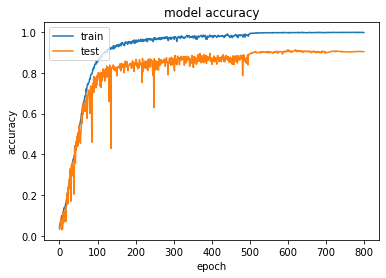

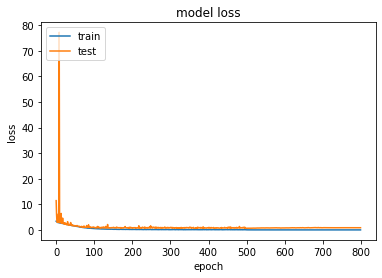

In [43]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()